# Работа.ру. Предсказание зарплат. 

## Сбор данных
<p style="font-size: 12pt">
    <b>Задача:</b>
В текущем датасете очень большой сдвиг в сторону рабочих профессий, что не позволяет масштабироваться, к примеру  в сторону "белых" воротничков. Поэтому предлагается написать парсер (не надо заморачиваться по поводу кода), с помощью которого мы могли бы обогатить наш датасет данными с trudsvem (https://trudvsem.ru/opendata/api) и hh (https://github.com/hhru/api) более офисными и инженерными профессиями при этом чтобы было хорошее разнообразие по регионам размещения вакансий.   Начинаем с trudsvem (https://trudvsem.ru/opendata/api), и если будет понимание что не будет хватать вакансий программистов , инженеров. юристов и аналитиков переходим к hh. 

<p style="font-size: 12pt">
На выходе должен быть небольшой готовый проект на питоне,  идеально если будет на приватном репозитории в  github.
Что важно: нужно дополнить текущий датасет (то есть не грузить все подряд), перед парсингом обязательно пришлите код мне на ревью (чтобы случайно не создавать лишнюю нагрузку на ресурсы).</p>

In [1]:
# подключение библиотек 
import requests
import re
import time
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# функция строит график распределения профессий
def plot_job_distr(*args):
    fig, ax = plt.subplots(figsize=(50, 10))
    
    if len(args) > 1:
        data = pd.concat(args, axis=0)
    else:
        data = args[0]

    sns.set_style("whitegrid")
    sns.histplot(
        data=data, x='custom_position', hue='tag', multiple='dodge',
        ax=ax,
        shrink=0.8    
    )
    plt.xticks(rotation=60, fontsize=20)
    plt.yticks(fontsize=20)
    ax.set_xlabel(xlabel='Job-name', fontsize=30)
    ax.set_ylabel(ylabel='Count', fontsize=30)
    fig.suptitle("Job distribution", fontsize=50)
    
    plt.setp(ax.get_legend().get_texts(), fontsize='28') # for legend text
    plt.setp(ax.get_legend().get_title(), fontsize='30') # for legend title

In [3]:
# функция создает датафрейм профессий и метки
def create_job_df(field, tag_name):
    data = pd.DataFrame(field)
    data.columns = ['custom_position']
    data['tag'] = tag_name
    return data

In [4]:
# унификация названий профессий
def unify_job_name(df, pos_dict):
    for index, row in df.iterrows():
        flag = False
        for key, value in pos_dict.items():
            if key in row['custom_position'].lower():
                df['custom_position'][index] = value
                flag = True
                break
        if not flag:
            # не попавшие в список удаляются (редкие)         
            df.drop([index], inplace=True)

### Загрузка датасета

In [5]:
df = pd.read_csv('./data/data_vacancies.csv')
df.drop(columns=['id', 'salary_pay_type'], inplace=True)

In [6]:
df.head(5)

,custom_position,schedule,salary_from,salary_to,offer_education_id,education_name,education_is_base,education_order_num,city_id,list_regions,work_skills,tags_id
0,Сварщик-сборщик,полный рабочий день,60000,120000,0,любое,True,0,2,[4],"['сварочные работы', 'сборка изделий по чертеж...",NaN
1,Сварщик-монтажник,полный рабочий день,60000,120000,0,любое,True,0,2,[4],"['монтажные работы', 'строительные работы', 'э...",NaN
2,Слесарь-сборщик,полный рабочий день,60000,80000,0,любое,True,0,2,[4],"['работа на фрезерных станках', 'слесарный рем...",NaN
3,Грузчик-упаковщик,частичная занятость,30000,35000,0,любое,True,0,1,[3],"['комплектация товара', 'маркировка', 'стрессо...","[6, 9]"
4,Грузчик-упаковщик,частичная занятость,30000,35000,0,любое,True,0,57,"[181, 182, 183, 185, 186, 187, 188, 189, 190, ...","['маркировка', 'стрессоустойчивость', 'погрузо...","[6, 9]"


### Анализ данных
Проанализируем распределение профессий. Для этого предобработаем(грубо) их названия в более общие.

In [7]:
pos_dict = {'менеджер': 'Менеджер/Администратор',
            'администратор': 'Менеджер/Администратор',
            'бухгалтер': 'Бухгалтер/Экономист',
            'экономист': 'Бухгалтер/Экономист',
            'секретарь': 'Бухгалтер/Экономист',
            'кассир': 'Кассир/Продавец/Консультант',
            'консультант': 'Кассир/Продавец/Консультант',
            'продавец': 'Кассир/Продавец/Консультант',
            'конструктор': 'Инженер/Механик',
            'технолог': 'Инженер/Механик',
            'пусконаладчик': 'Инженер/Механик',
            'инженер кип': 'Инженер/Механик',
            'инженер-сметчик': 'Инженер/Механик',
            'слесарь': 'Инженер/Механик',
            'сварщик': 'Инженер/Механик',
            'электрик': 'Инженер/Механик',  
            'монтажник': 'Инженер/Механик',
            'механик': 'Инженер/Механик',
            'проектировщик': 'Инженер/Механик',
            'кабельщик': 'Инженер/Механик',
            'наладчик': 'Инженер/Механик',
            'помощник Инженера ПТО': 'Инженер/Механик',
            'инженер по ремонту и обслуживанию оборудования': 'Инженер/Механик',
            'автомеханик': 'Инженер/Механик',
            'сверловщик': 'Инженер/Механик', 
            'фрезеровщик': 'Инженер/Механик', 
            'инженер': 'Инженер/Механик', 
            'инструктор по вождению': 'Инструктор/Тренер',
            'тренер': 'Инструктор/Тренер',
            'инструктор': 'Инструктор/Тренер',
            'водитель': 'Водитель',
            'оператор': 'Оператор/Диспетчер',
            'диспетчер': 'Оператор/Диспетчер',
            'учитель': 'Учитель/Преподаватель',
            'воспитатель': 'Учитель/Преподаватель',
            'педагог': 'Учитель/Преподаватель',
            'преподаватель': 'Учитель/Преподаватель',
            'программист': 'Разработчик/Аналитик',
            'бизнес-аналитик': 'Разработчик/Аналитик',
            'разработчик': 'Разработчик/Аналитик',
            'дата сайентист': 'Разработчик/Аналитик',
            'копирайтер': 'Разработчик/Аналитик', 
            'домработница': 'Уборщик/Сиделка/Няня',
            'швея': 'Уборщик/Сиделка/Няня', 
            'мастер в ателье': 'Уборщик/Сиделка/Няня', 
            'сиделка': 'Уборщик/Сиделка/Няня',
            'няня': 'Уборщик/Сиделка/Няня',
            'горничная': 'Уборщик/Сиделка/Няня', 
            'кастелянша': 'Уборщик/Сиделка/Няня',  
            'уборщик': 'Уборщик/Сиделка/Няня',
            'уборщица': 'Уборщик/Сиделка/Няня',
            'прачеч': 'Уборщик/Сиделка/Няня', 
            'повар': 'Повар/Шеф/Официант/Бармен', 
            'шеф': 'Повар/Шеф/Официант/Бармен', 
            'пекарь': 'Повар/Шеф/Официант/Бармен', 
            'сушист': 'Повар/Шеф/Официант/Бармен',
            'бармен': 'Повар/Шеф/Официант/Бармен',
            'официант': 'Повар/Шеф/Официант/Бармен',
            'бариста': 'Повар/Шеф/Официант/Бармен', 
            'грузчик': 'Грузчик/Курьер',
            'курьер': 'Грузчик/Курьер',
            'упаковщик': 'Упаковщик/Сборщик/Комплектовщик',
            'кладовщик': 'Упаковщик/Сборщик/Комплектовщик',
            'сборщик': 'Упаковщик/Сборщик/Комплектовщик',
            'комплектовщик': 'Упаковщик/Сборщик/Комплектовщик',
            'маркировщик': 'Упаковщик/Сборщик/Комплектовщик',
            'сортировщик': 'Упаковщик/Сборщик/Комплектовщик',
            'мебельщик': 'Упаковщик/Сборщик/Комплектовщик',
            'фасовщик': 'Упаковщик/Сборщик/Комплектовщик',
            'плотник': 'Рабочий/Строитель/Мастер',
            'маляр': 'Рабочий/Строитель/Мастер',
            'разнорабочий': 'Рабочий/Строитель/Мастер', 
            'рабочий': 'Рабочий/Строитель/Мастер', 
            'строитель': 'Рабочий/Строитель/Мастер',
            'мастер по ремонту окон': 'Рабочий/Строитель/Мастер', 
            'дорожный рабочий': 'Рабочий/Строитель/Мастер', 
            'мойщик': 'Рабочий/Строитель/Мастер',
            'охранник': 'Рабочий/Строитель/Мастер',
            'врач': 'Врач/Массажист',
            'доктор': 'Врач/Массажист',
            'медбрат': 'Врач/Массажист',
            'медсестра': 'Врач/Массажист',
            'медицинский': 'Врач/Массажист',
            'медицинская': 'Врач/Массажист',
            'массажист': 'Врач/Массажист', 
            'дизайнер': 'Дизайнер',
            'почтальон': 'Почтальон', 
            'дежурный': 'Дежурный',
            'парикмахер': 'Парикмахер/Cтилист/Визажист',
            'стилист': 'Парикмахер/Cтилист/Визажист',
            'визажист': 'Парикмахер/Cтилист/Визажист',
            'юрист': 'Юрист/Нотариус',
            'нотариус': 'Юрист/Нотариус',
            'переводчик': 'Переводчик/Пресс-служба', 
            'сотрудник пресс-службы': 'Переводчик/Пресс-служба',
           } 


In [8]:
unify_job_name(df, pos_dict)

<ipython-input-4-d3f23ddace91>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['custom_position'][index] = value


In [9]:
# set(df['custom_position'].unique()) - set(pos_dict.values())

In [10]:
df['custom_position'].unique().shape

(21,)

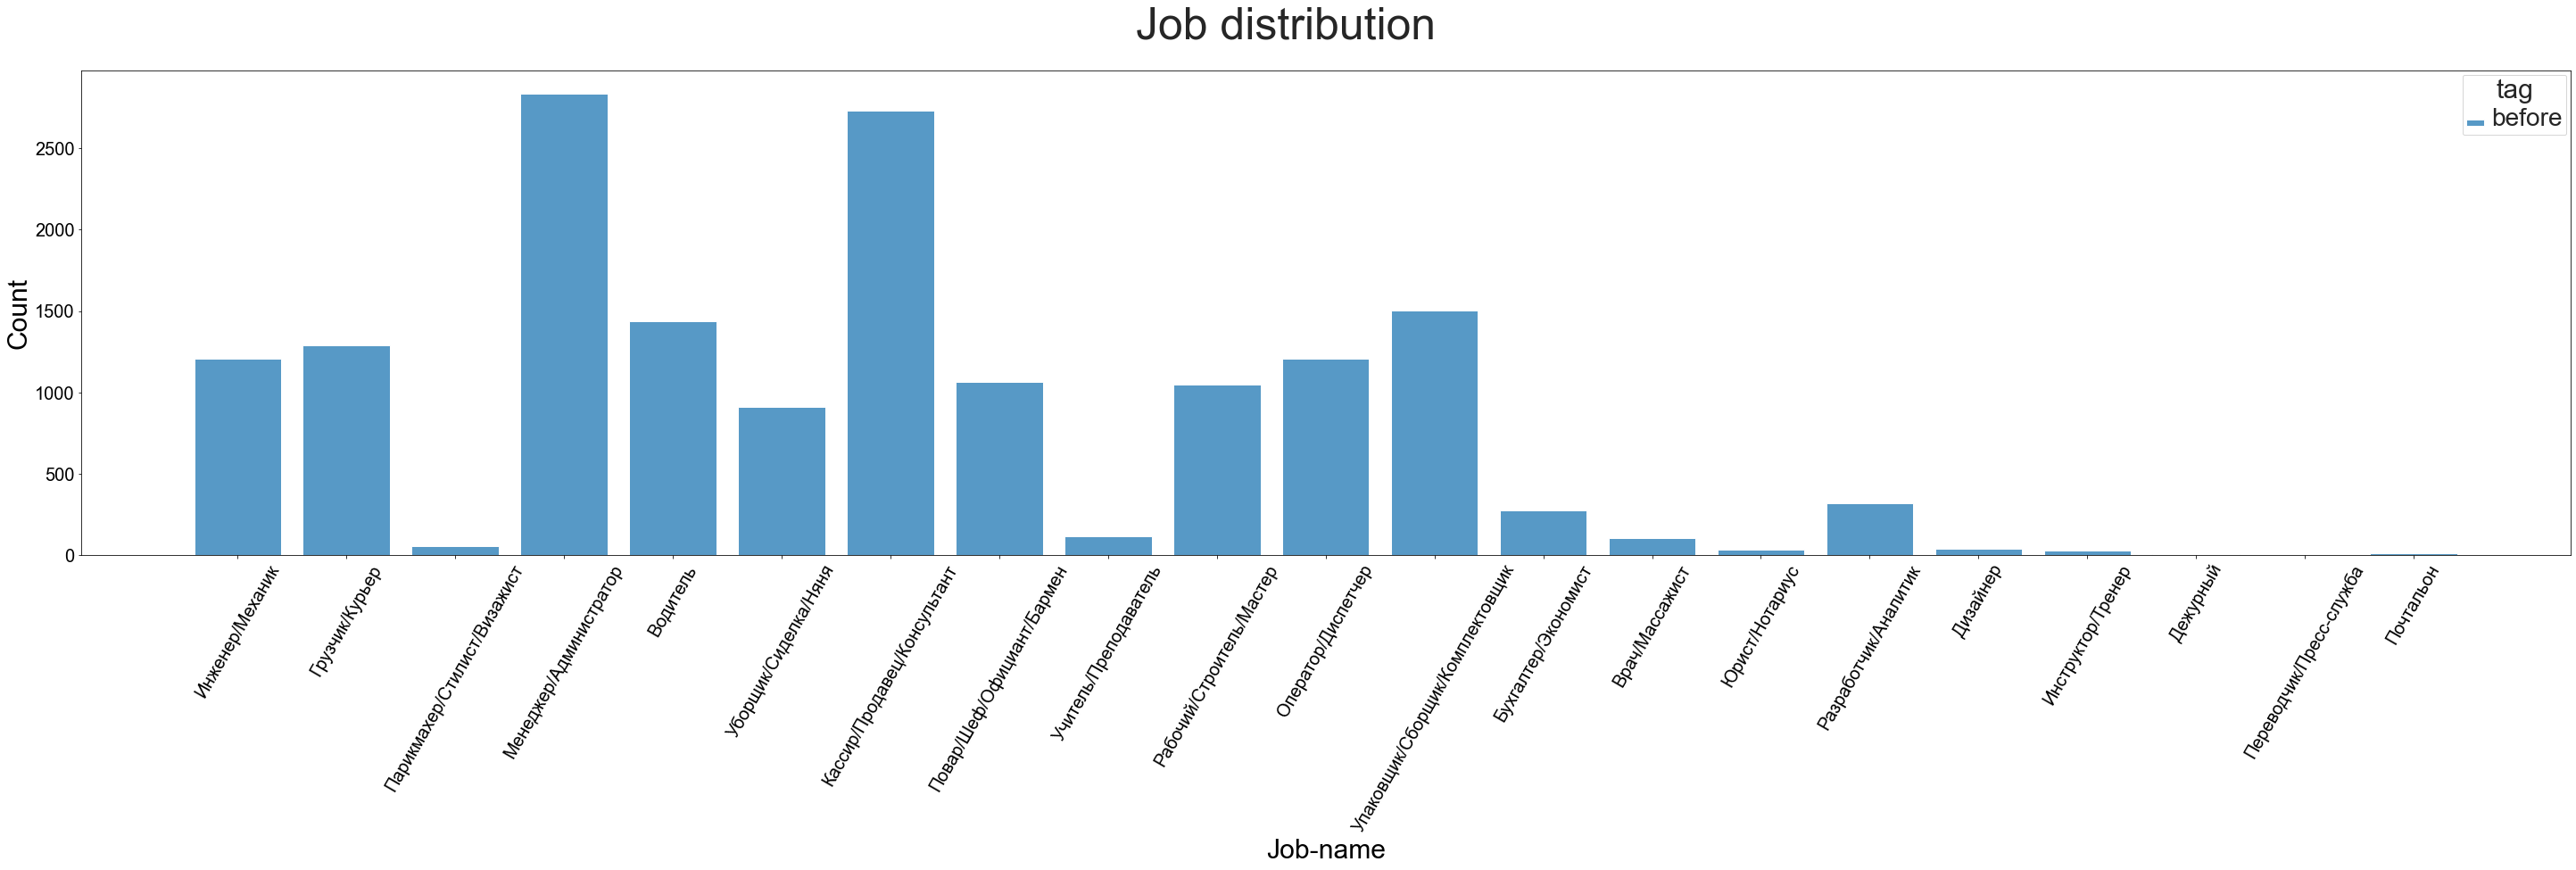

In [11]:
data = create_job_df(df['custom_position'], tag_name='before')
plot_job_distr(data)

Из распределения видно, что оно неравномерное. \
Необходимо наполнить недостающими данными.

### Сбор данных
Оставим поля профессий, для которых недостает данных

In [12]:
pos_dict.pop('менеджер')
pos_dict.pop('администратор')
pos_dict.pop('кассир')
pos_dict.pop('консультант')
pos_dict.pop('продавец')

'Кассир/Продавец/Консультант'

#### trudvsem

##### Сбор данных

In [13]:
# items = []
# index = 0

# for i in range(0, 200):
#     index = i
#     url = "http://opendata.trudvsem.ru/api/v1/vacancies?offset={}&limit=100".format(str(i))
#     item = [elem['vacancy'] for elem in requests.get(url).json()['results']['vacancies']]
#     items += item

In [14]:
# print(index)
# print(len(items))

In [15]:
# df_2 = pd.DataFrame(items)
# df_2.drop(columns=['id', 'code_profession', 'creation-date', 'vac_url', 'addresses', 'contact_list', 'contact_person'], inplace=True)
# df_2.to_csv('data_trudsvem.csv', index=False)

##### Загрузка данных

In [16]:
df_trudvsem = pd.read_csv('./data/data_trudsvem.csv')
df_trudvsem.rename(columns={'job-name': 'custom_position'}, inplace=True)
df_trudvsem.head(5)

,source,region,company,salary,salary_min,salary_max,custom_position,employment,schedule,duty,category,requirement,social_protected,work_places,currency,term
0,Работодатель,"{'region_code': '6100000000000', 'name': 'Рост...",{'companycode': '851a6350-b74c-11ed-9896-97192...,от 19000,19000,23000,Инженер по метрологии,Полная занятость,Полный рабочий день,<p>Качественное выполнение должностных обязанн...,"{'specialisation': 'Безопасность, службы охраны'}","{'education': 'Высшее', 'experience': 0}",NaN,1,«руб.»,NaN
1,Работодатель,"{'region_code': '6100000000000', 'name': 'Рост...","{'companycode': '1046151001313', 'email': 'nov...",от 25000,25000,30000,электрогазосварщик,Полная занятость,Полный рабочий день,<p>проведение сварочных работ</p>,"{'specialisation': 'ЖКХ, эксплуатация'}","{'education': 'Не указано', 'experience': 1}",NaN,1,«руб.»,NaN
2,Работодатель,"{'region_code': '6100000000000', 'name': 'Рост...",{'companycode': '851a6350-b74c-11ed-9896-97192...,от 20000,20000,25000,ведущий инженер по метрологии,Полная занятость,Полный рабочий день,<p>Качественное выполнение должностных обязанн...,"{'specialisation': 'Безопасность, службы охраны'}","{'education': 'Высшее', 'experience': 0}",NaN,1,«руб.»,NaN
3,Работодатель,"{'region_code': '7700000000000', 'name': 'Горо...","{'companycode': '1027739677228', 'email': 'usp...",от 136500,136500,0,Начальник отдела аналитики,Полная занятость,Полный рабочий день,"<ul>\n<li>сбор и анализ требований, взаимодейс...","{'specialisation': 'Информационные технологии,...","{'education': 'Высшее', 'qualification': '<ul>...",NaN,1,«руб.»,NaN
4,Работодатель,"{'region_code': '5700000000000', 'name': 'Орло...","{'companycode': '1125744000304', 'email': 'ckk...",от 41054,41054,41054,Подсобный рабочий,Полная занятость,Сменный график,— Ведение процесса очистки зерна и продуктов ш...,{'specialisation': 'Производство'},"{'education': 'Среднее', 'qualification': '<p>...",NaN,10,«руб.»,"{'text': 'Социальный пакет, сменный график раб..."


In [17]:
unify_job_name(df_trudvsem, pos_dict)

<ipython-input-4-d3f23ddace91>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['custom_position'][index] = value


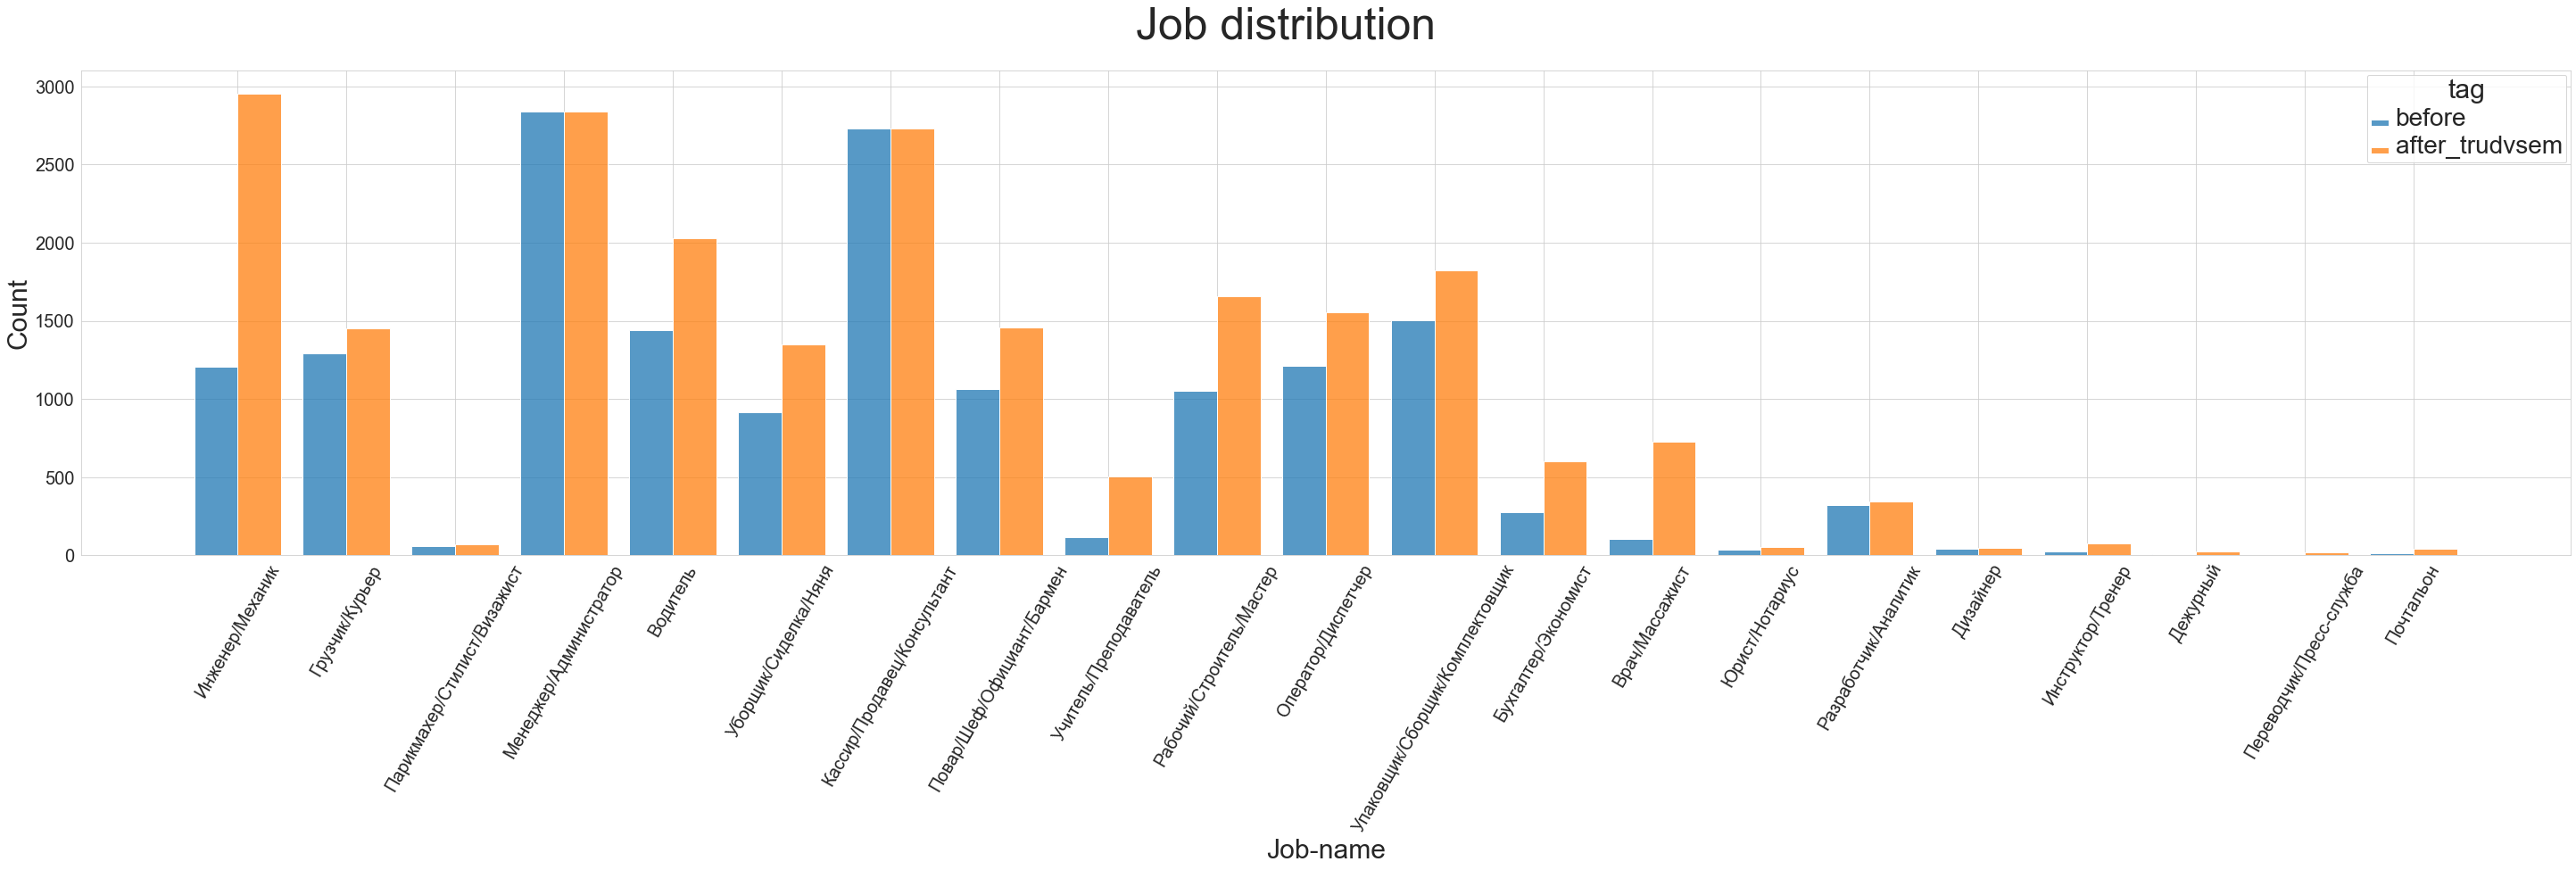

In [18]:
data_trudvsem = pd.concat([data['custom_position'], df_trudvsem['custom_position']], axis=0)
data_trudvsem = create_job_df(data_trudvsem, tag_name='after_trudvsem')
plot_job_distr(data, data_trudvsem)

#### hh.ru

In [19]:
pos_dict.pop('конструктор')
pos_dict.pop('технолог')
pos_dict.pop('пусконаладчик')
pos_dict.pop('инженер кип')
pos_dict.pop('инженер-сметчик')
pos_dict.pop('слесарь')
pos_dict.pop('сварщик')
pos_dict.pop('электрик')
pos_dict.pop('монтажник')
pos_dict.pop('механик')
pos_dict.pop('проектировщик')
pos_dict.pop('кабельщик')
pos_dict.pop('наладчик')
pos_dict.pop('помощник Инженера ПТО')
pos_dict.pop('инженер по ремонту и обслуживанию оборудования')
pos_dict.pop('автомеханик')
pos_dict.pop('сверловщик')
pos_dict.pop('фрезеровщик')
pos_dict.pop('инженер')

'Инженер/Механик'

##### Сбор данных

In [20]:
# items = []
# index = 0

# for i in range(0, 200):
#     index = i
#     url = "https://api.hh.ru/vacancies?per_page=100&page={}".format(str(0))
#     item = requests.get(url).json()['items']
#     items += item

In [21]:
# print(len(items))
# print(index)

In [22]:
# df_3 = pd.DataFrame(items)
# df_3.drop(['id', 'address', 'premium'], axis=1, inplace=True)
# df_3.to_csv('data_hh.csv', index=False)

##### Загрузка данных

In [23]:
df_hh = pd.read_csv('./data/data_hh.csv')
df_hh.rename(columns={'name': 'custom_position'}, inplace=True)
df_hh.head(5)

,custom_position,department,has_test,response_letter_required,area,salary,type,response_url,sort_point_distance,published_at,...,working_time_intervals,working_time_modes,accept_temporary,professional_roles,accept_incomplete_resumes,experience,employment,adv_response_url,is_adv_vacancy,branding
0,"Диспетчер чатов, удаленно",NaN,False,False,"{'id': '113', 'name': 'Россия', 'url': 'https:...","{'from': 30000, 'to': 44000, 'currency': 'RUR'...","{'id': 'open', 'name': 'Открытая'}",NaN,NaN,2023-09-29T18:28:04+0300,...,[],"[{'id': 'start_after_sixteen', 'name': 'Можно ...",False,"[{'id': '40', 'name': 'Другое'}]",True,"{'id': 'noExperience', 'name': 'Нет опыта'}","{'id': 'full', 'name': 'Полная занятость'}",NaN,False,NaN
1,"Оператор на входящие сообщения (удаленно, в Ян...",NaN,False,False,"{'id': '113', 'name': 'Россия', 'url': 'https:...","{'from': 30000, 'to': 44000, 'currency': 'RUR'...","{'id': 'open', 'name': 'Открытая'}",NaN,NaN,2023-09-29T18:30:48+0300,...,[],"[{'id': 'start_after_sixteen', 'name': 'Можно ...",False,"[{'id': '40', 'name': 'Другое'}]",True,"{'id': 'noExperience', 'name': 'Нет опыта'}","{'id': 'full', 'name': 'Полная занятость'}",NaN,False,NaN
2,"Менеджер чатов, удалённо (в Яндекс)",NaN,False,False,"{'id': '113', 'name': 'Россия', 'url': 'https:...","{'from': 30000, 'to': 44000, 'currency': 'RUR'...","{'id': 'open', 'name': 'Открытая'}",NaN,NaN,2023-09-29T18:21:19+0300,...,[],"[{'id': 'start_after_sixteen', 'name': 'Можно ...",False,"[{'id': '40', 'name': 'Другое'}]",True,"{'id': 'noExperience', 'name': 'Нет опыта'}","{'id': 'full', 'name': 'Полная занятость'}",NaN,False,NaN
3,Менеджер чатов на дому (в Яндекс),NaN,False,False,"{'id': '113', 'name': 'Россия', 'url': 'https:...","{'from': 30000, 'to': 44000, 'currency': 'RUR'...","{'id': 'open', 'name': 'Открытая'}",NaN,NaN,2023-09-29T18:23:45+0300,...,[],"[{'id': 'start_after_sixteen', 'name': 'Можно ...",False,"[{'id': '40', 'name': 'Другое'}]",True,"{'id': 'noExperience', 'name': 'Нет опыта'}","{'id': 'full', 'name': 'Полная занятость'}",NaN,False,NaN
4,Менеджер по продажам услуг,NaN,False,False,"{'id': '1002', 'name': 'Минск', 'url': 'https:...",NaN,"{'id': 'open', 'name': 'Открытая'}",NaN,NaN,2023-09-25T09:04:59+0300,...,[],[],True,"[{'id': '70', 'name': 'Менеджер по продажам, м...",False,"{'id': 'noExperience', 'name': 'Нет опыта'}","{'id': 'full', 'name': 'Полная занятость'}",NaN,False,NaN


In [24]:
unify_job_name(df_hh, pos_dict)

<ipython-input-4-d3f23ddace91>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['custom_position'][index] = value


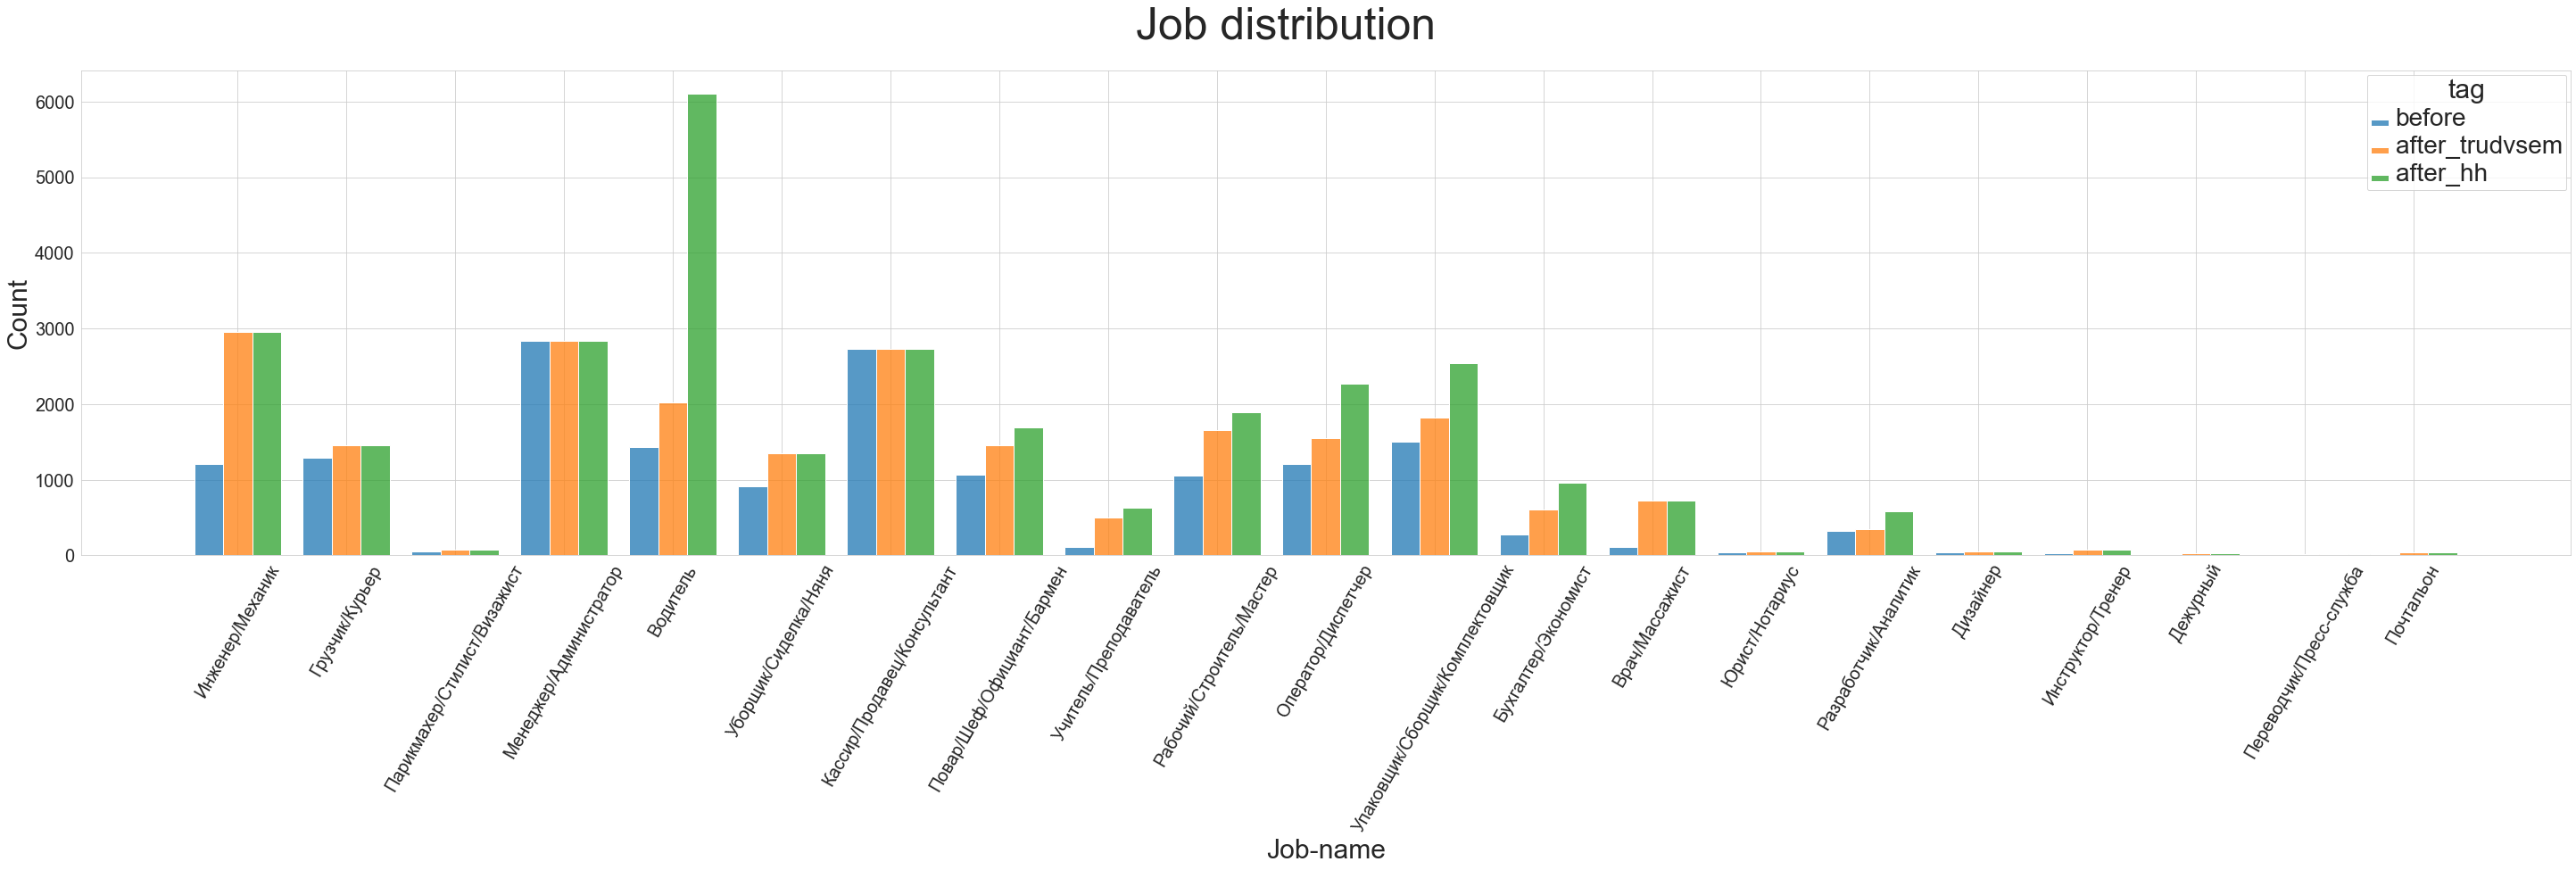

In [25]:
data_hh = pd.concat([data_trudvsem['custom_position'], df_hh['custom_position']], axis=0)
data_hh = create_job_df(data_hh, tag_name='after_hh')
plot_job_distr(data, data_trudvsem, data_hh)

#### hh.ru. individual

In [26]:
pos_dict.pop('водитель')

'Водитель'

##### Сбор данных

In [27]:
# items = []
# index = 0

# for key, value in list(pos_dict_to_add.items()):
#     for i in range(0, 10):
#         index = i
#         url = f"https://api.hh.ru/vacancies?text={key}&&search_field=name&per_page=100&page={i}"
#         item = requests.get(url).json()['items']
#         items += item
#         time.sleep(random.random())
#     print(key)
#     time.sleep(random.random() * 10)

In [28]:
# len(items)

In [29]:
# df_4 = pd.DataFrame(items)
# df_4.drop(['id', 'address', 'premium'], axis=1, inplace=True)
# df_4.to_csv('data2_hh.csv', index=False)

##### Загрузка данных

In [30]:
df_hh_ind = pd.read_csv('./data/data_hh_ind.csv')
df_hh_ind.rename(columns={'name': 'custom_position'}, inplace=True)
df_hh_ind.head(5)

C:\Users\kshch\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (7,33) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,custom_position,department,has_test,response_letter_required,area,salary,type,response_url,sort_point_distance,published_at,...,accept_temporary,professional_roles,accept_incomplete_resumes,experience,employment,adv_response_url,is_adv_vacancy,branding,immediate_redirect_url,immediate_redirect_vacancy_id
0,Бухгалтер (производство),NaN,False,False,"{'id': '88', 'name': 'Казань', 'url': 'https:/...","{'from': 70000, 'to': None, 'currency': 'RUR',...","{'id': 'open', 'name': 'Открытая'}",NaN,NaN,2023-10-12T16:27:13+0300,...,False,"[{'id': '18', 'name': 'Бухгалтер'}]",False,"{'id': 'between3And6', 'name': 'От 3 до 6 лет'}","{'id': 'full', 'name': 'Полная занятость'}",NaN,False,NaN,NaN,NaN
1,Заместитель главного бухгалтера,NaN,False,False,"{'id': '88', 'name': 'Казань', 'url': 'https:/...","{'from': 75000, 'to': None, 'currency': 'RUR',...","{'id': 'open', 'name': 'Открытая'}",NaN,NaN,2023-10-20T15:48:48+0300,...,False,"[{'id': '18', 'name': 'Бухгалтер'}]",False,"{'id': 'between3And6', 'name': 'От 3 до 6 лет'}","{'id': 'full', 'name': 'Полная занятость'}",NaN,False,NaN,NaN,NaN
2,Бухгалтер - участок первичной документации,NaN,False,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...","{'from': 75000, 'to': 75000, 'currency': 'RUR'...","{'id': 'open', 'name': 'Открытая'}",NaN,NaN,2023-10-05T14:25:34+0300,...,False,"[{'id': '18', 'name': 'Бухгалтер'}]",False,"{'id': 'between3And6', 'name': 'От 3 до 6 лет'}","{'id': 'full', 'name': 'Полная занятость'}",NaN,False,NaN,NaN,NaN
3,Бухгалтер/Главный бухгалтер (удаленно),NaN,False,False,"{'id': '2', 'name': 'Санкт-Петербург', 'url': ...",NaN,"{'id': 'open', 'name': 'Открытая'}",NaN,NaN,2023-10-24T15:57:10+0300,...,False,"[{'id': '18', 'name': 'Бухгалтер'}]",False,"{'id': 'between3And6', 'name': 'От 3 до 6 лет'}","{'id': 'full', 'name': 'Полная занятость'}",NaN,False,NaN,NaN,NaN
4,Бухгалтер,NaN,False,False,"{'id': '58', 'name': 'Липецк', 'url': 'https:/...","{'from': 70000, 'to': 90000, 'currency': 'RUR'...","{'id': 'open', 'name': 'Открытая'}",NaN,NaN,2023-10-24T10:53:51+0300,...,False,"[{'id': '18', 'name': 'Бухгалтер'}]",False,"{'id': 'between1And3', 'name': 'От 1 года до 3...","{'id': 'full', 'name': 'Полная занятость'}",NaN,False,NaN,NaN,NaN


In [31]:
unify_job_name(df_hh_ind, pos_dict)

<ipython-input-4-d3f23ddace91>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['custom_position'][index] = value


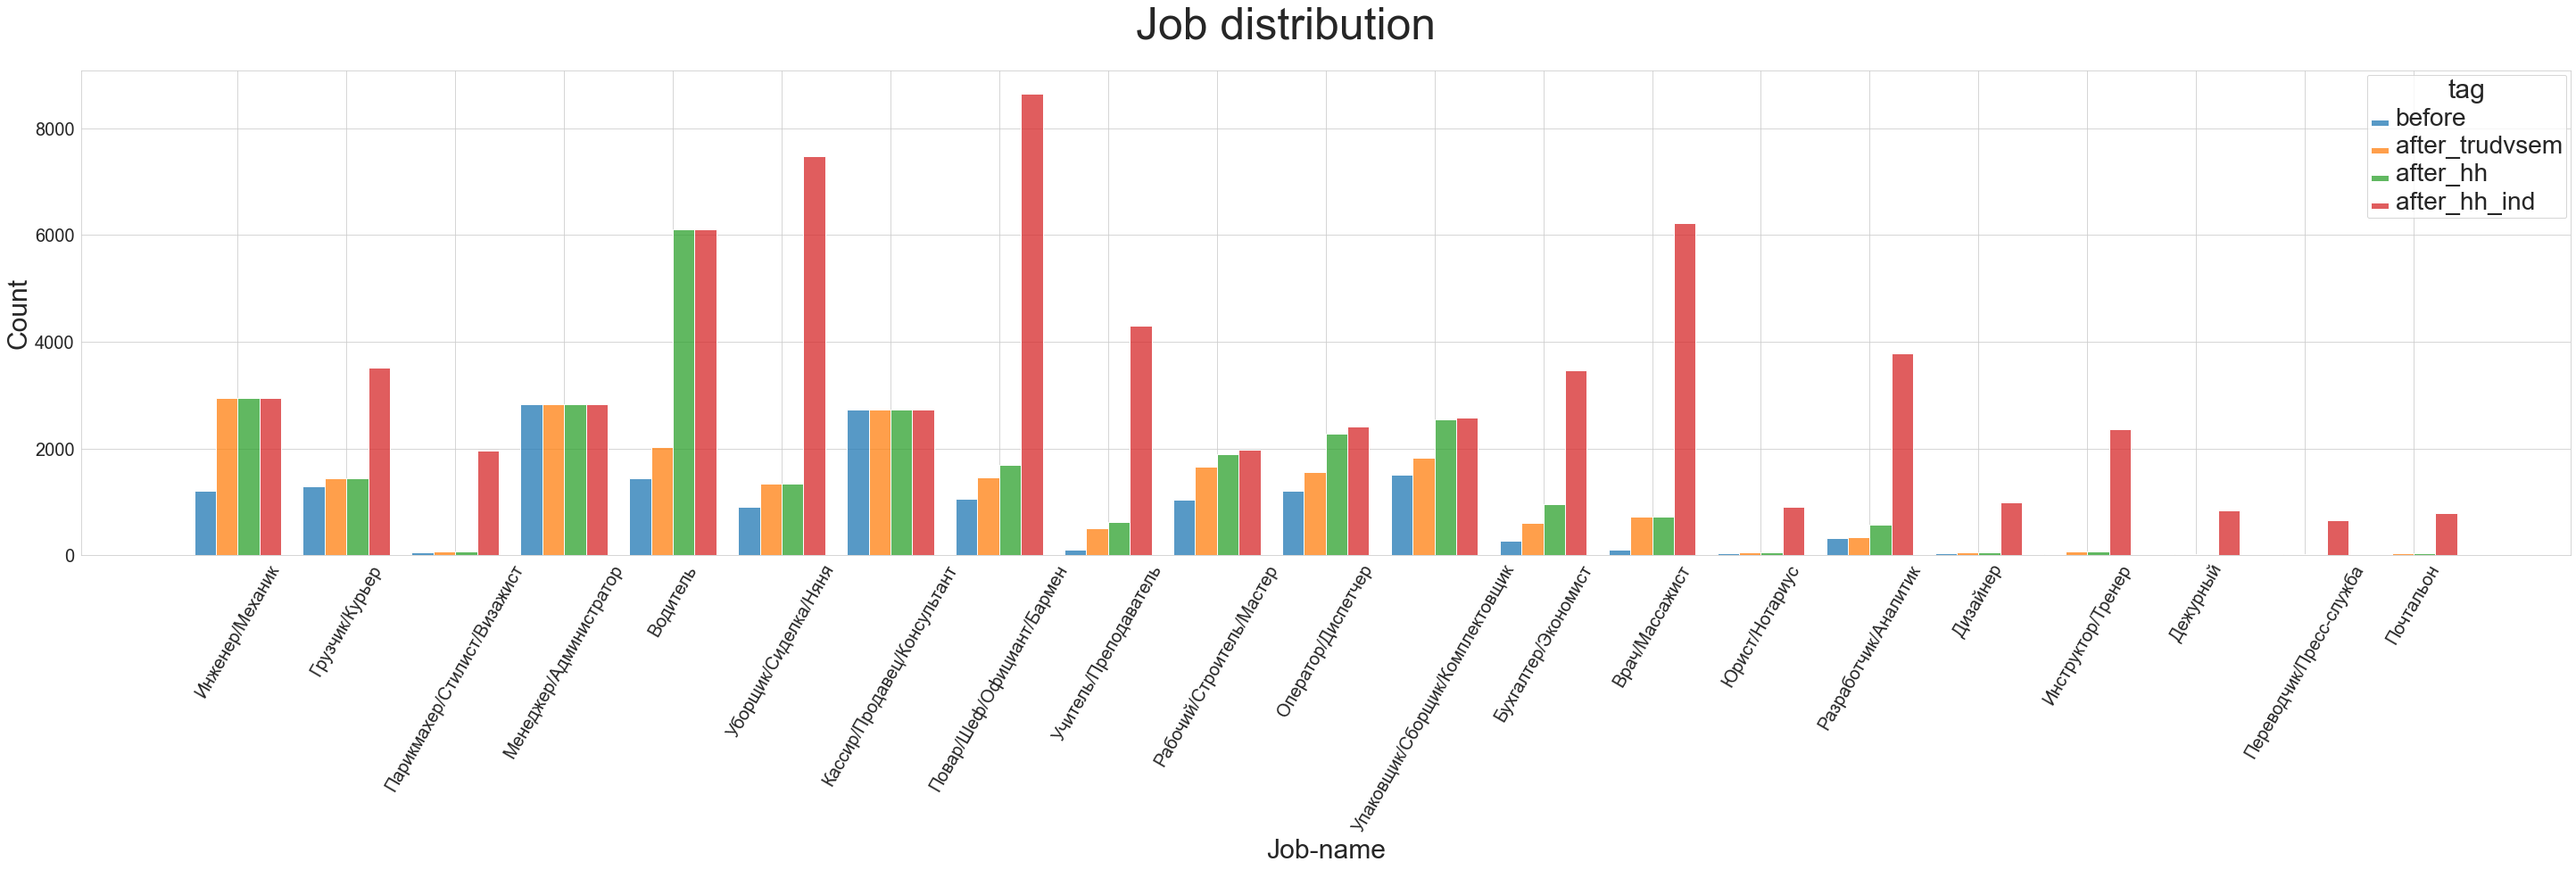

In [32]:
data_hh_ind = pd.concat([data_hh['custom_position'], df_hh_ind['custom_position']], axis=0)
data_hh_ind = create_job_df(data_hh_ind, tag_name='after_hh_ind')
plot_job_distr(data, data_trudvsem, data_hh, data_hh_ind)

### Заключение

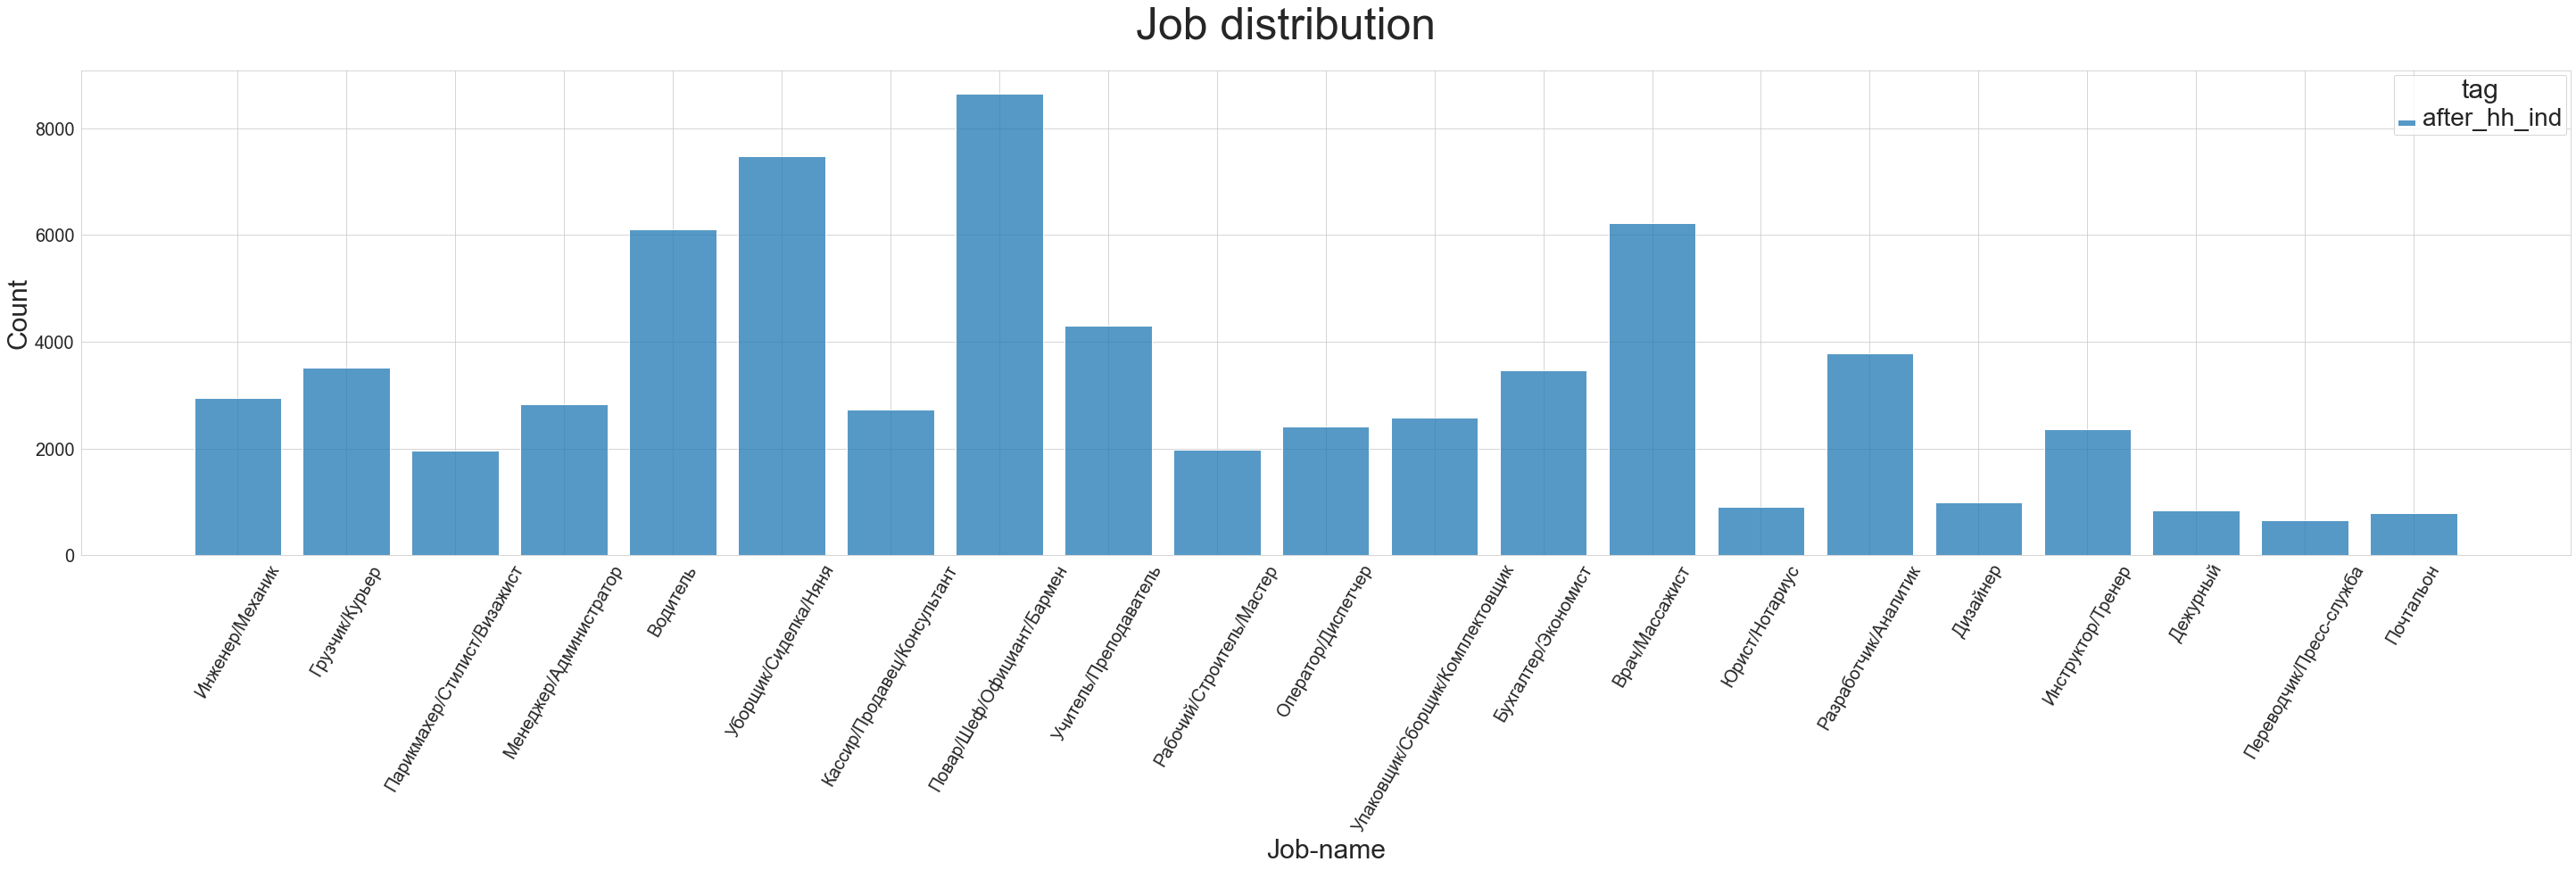

In [33]:
plot_job_distr(data_hh_ind)

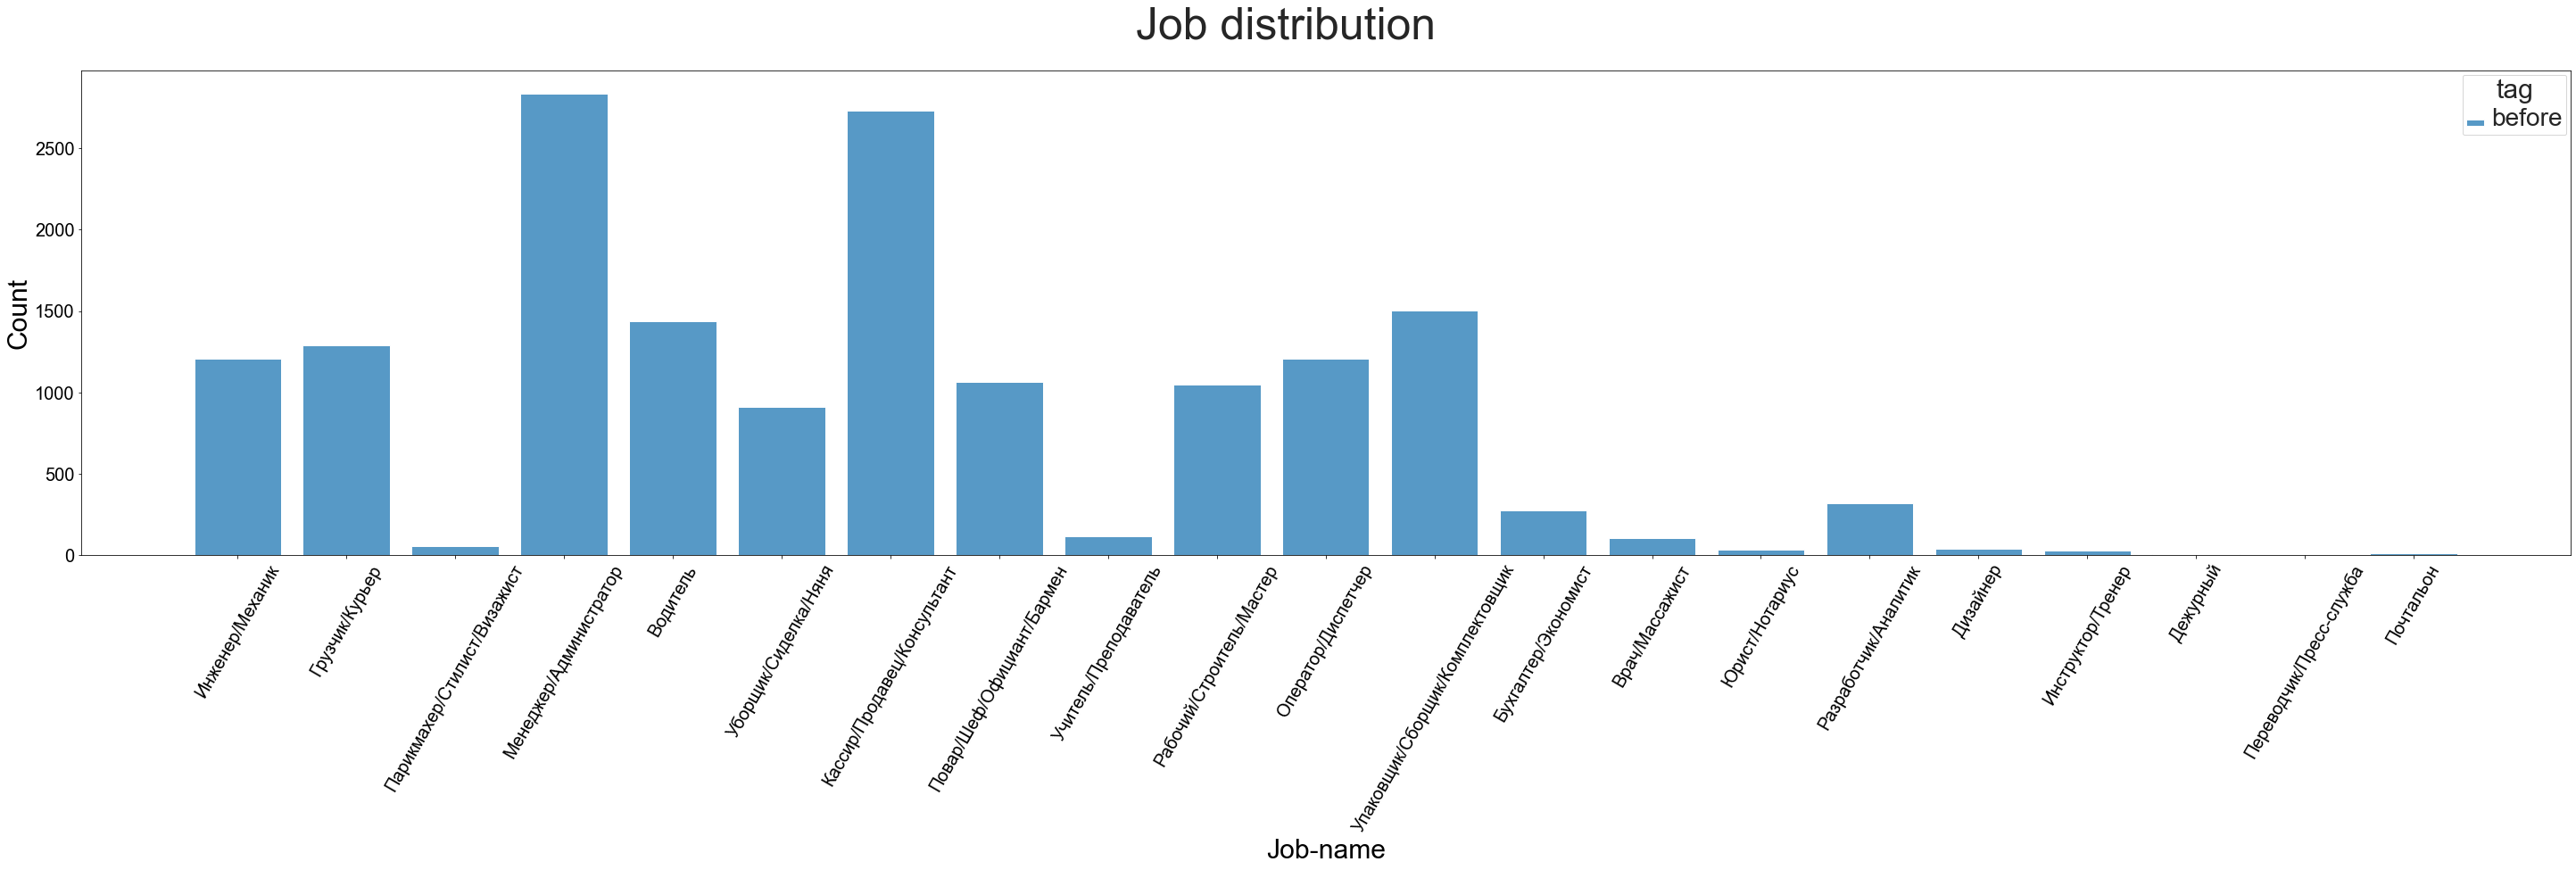

<p style="font-size: 12pt"><b>По итогу</b> работы удалось увеличить общий объем датасета (цена деления изменилась с 500 до 2000), увеличить количество данных для редких профессий, приблизить распределение профессий к равномерному (стало более плавное).</p>
<p style="font-size: 12pt">Однако не было сделано акцента на разнообразие вакансий по регионам.</p>
<p style="font-size: 12pt"><b>Нужно сделать</b> унификацию полученных данных.</p>